- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [80]:
import wandb
import numpy as np

In [81]:
import wandb

#default param
run_config = dict(
    sr=16000,
    n_mels=128,
    win_length =  300,
    n_fft= 2048,
    hop_length= 50,
    f_max = 8000    
)


In [82]:
# n_mels

sweep_config = {
    "project" : "SVD-voice-disorder",
    "name": "melspectrogram-seed1004",
  "method": "random",
  "parameters": {
      "n_mels" :{
           "values":np.arange(50,192,10).tolist()
       },
      "win_length": {
            "values": np.arange(50,4096,10).tolist()
        },       
      "n_fft": {
            "values": np.arange(50,4096,10).tolist() # 제일 중요한 파라미터. 윈도우에서 몇만큼의 데이터를 사용하고 나머지 패딩할지
        },
       "hop_length": {
          "values": np.arange(50,1000,50).tolist()
      },
    }
}

sweep_id = wandb.sweep(sweep_config,project="SVD-hyp-sweep2",entity="bub3690")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: l4lhk2pf
Sweep URL: https://wandb.ai/bub3690/SVD-hyp-sweep2/sweeps/l4lhk2pf


In [83]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

from Utils.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [84]:
import torchaudio
#import torchaudio.functional as F
import torchaudio.transforms as T

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(1234)

# SVD 문장 데이터에서 Feature 추출
- mfcc

In [85]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [86]:
speaker_data=pd.read_excel("../../voice_data/only_organics_healthy_available.xlsx")

In [87]:
pathology = speaker_data[speaker_data['PATHOLOGY']=='p']['SPEAKER'].unique().tolist()
healthy = speaker_data[speaker_data['PATHOLOGY']=='n']['SPEAKER'].unique().tolist()
print(len(pathology))
print(len(healthy))

427
630


In [88]:
#겹치는 speaker는 곱하기 100을 해준다.
#3명이 겹친다.
changed_patients = list(set(healthy) & set(pathology))

for patient in changed_patients:
    temp=pathology[pathology.index(patient)]*100
    pathology[pathology.index(patient)] = temp
    

In [89]:
#train test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


random_state = 1004 # 1004,1005,1006,1007,1008

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<427:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=random_state) #456
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")



총 데이터수 :  1057
---
훈련 셋 :  845 Counter({'healthy': 504, 'pathology': 341})
테스트 셋 :  212 Counter({'healthy': 126, 'pathology': 86})
---


## 2. stratified k-fold

In [90]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 273}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 273}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 273}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 403, 'pathology': 273}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 68} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 404, 'pathology': 272}
검증 레이블 데이터 분포 : 
 {'healthy': 100, 'pathology': 69} 



# speaker to voice

In [91]:
# speaker to voice

all_train_record_list = []
all_valid_record_list = []
all_test_record_list = []

all_train_label_list = []
all_valid_label_list = []
all_test_label_list = []

#train
for fold_idx,fold in enumerate(X_train_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[speaker_data['SPEAKER']==speaker]['RECORDING'].tolist()
        label_list = [ Y_train_list[fold_idx][idx] ] * len(record_list)
        
        fold_record += record_list
        fold_y_record += label_list
    all_train_record_list.append(fold_record)
    all_train_label_list.append(fold_y_record)

    
#valid
for fold_idx,fold in enumerate(X_valid_list):
    fold_record=[]
    fold_y_record=[]
    for idx,speaker in enumerate(fold):
        record_list = speaker_data[speaker_data['SPEAKER']==speaker]['RECORDING'].tolist()
        label_list = [ Y_valid_list[fold_idx][idx] ] * len(record_list)
        
        fold_record += record_list
        fold_y_record += label_list
    all_valid_record_list.append(fold_record)
    all_valid_label_list.append(fold_y_record)
    
#test
fold_record=[]
fold_y_record=[]
for idx,speaker in enumerate(X_test):
    record_list = speaker_data[speaker_data['SPEAKER']==speaker]['RECORDING'].tolist()
    label_list = [ Y_test[idx] ] * len(record_list)
    fold_record += record_list
    fold_y_record += label_list
all_test_record_list = fold_record
all_test_label_list = fold_y_record


X_train_list = all_train_record_list
X_valid_list = all_valid_record_list
X_test = all_test_record_list

Y_train_list = all_train_label_list
Y_valid_list = all_valid_label_list
Y_test = all_test_label_list



## 3. random over sampling

In [92]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res





 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 373})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold1 
before dataset shape Counter({'healthy': 409, 'pathology': 374})
Resampled dataset shape Counter({'healthy': 409, 'pathology': 409})

 fold2 
before dataset shape Counter({'healthy': 409, 'pathology': 400})
Resampled dataset shape Counter({'healthy': 409, 'pathology': 409})

 fold3 
before dataset shape Counter({'healthy': 410, 'pathology': 407})
Resampled dataset shape Counter({'healthy': 410, 'pathology': 410})

 fold4 
before dataset shape Counter({'healthy': 410, 'pathology': 390})
Resampled dataset shape Counter({'pathology': 410, 'healthy': 410})


In [93]:
X_res

array([[1803, 1034,    5,   61, 2126,   33, 1106, 2218, 1871,  365, 1120,
        1986,   16, 2262, 1438, 1652, 1666, 1672, 1677, 1689, 1723, 1762,
        1769, 1914, 1945, 1961, 1994, 2022, 2159, 2352, 2361, 2397, 2485,
        1587,   45, 1732, 2283, 1399, 2507, 1169, 1743, 1863,  993, 1549,
         683, 1046, 2153, 2330, 1372, 1517, 1719, 1789, 1534, 1957,  632,
         825,  691, 1820,  876,  565, 1136,  709, 1167, 1091,  943,  979,
        1840, 1102, 1140,  989,  861, 2567,  842, 1854, 2286,   34,  992,
         841,  931, 1500, 1416, 2206,  721, 1830,  679, 1912, 2260,   54,
         122, 2414, 2574,  867,  928, 1105, 1540,  119, 1269, 1614, 1930,
        2296,  704, 1351, 1216, 1699, 1870, 1847,   15,  929,   71, 1142,
         952, 2565, 2591, 2493, 1725,    9, 2602, 1437,  702, 1078, 1366,
        1535, 1953, 1917, 2595,  725, 1604, 1901, 1809,   30, 1075, 1356,
        2394, 1536,    2, 1013,  500,   47, 1137, 1123, 2492,  932, 1969,
        1347, 2381, 1352, 2562,  844, 

In [94]:
import pickle


    
#load
with open("../../voice_data/organics/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

#with open("../../voice_data/organics/phrase_minmax_scaler_hyper.pickle","rb") as fr:
#    phrase_scaler = pickle.load(fr)
    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [95]:
# 데이터 로더

In [96]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","pathology"]


class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,mel_params,transform=None,normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
        
        # sweep params
        self.mel_params = mel_params
        # hop_length , win_length , n_mels , n_fft , f_max , batch_size
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        """
        sig = phrase_dict[ str(self.path_list[idx])+'-phrase.wav'] 
        #sig = preemphasis(sig)
        origin_length = sig.shape[0]
        
        #if sig.shape[0] > self.mel_params["sr"]*2:
        #    origin_length = self.mel_params["sr"]*2
        
        #origin_frame_size = 1 + int(np.floor(origin_length//self.mel_params["hop_length"]))
        
        length = self.mel_params["sr"]*2 #sample rate *2 padding을 위한 파라미터 (하이퍼 파라미터로인해 사이즈는 계속 바뀐다.)
        pad1d = lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###
        
        mel_feature = librosa.feature.melspectrogram(y=sig,
                                                     sr=self.mel_params["sr"],
                                                     # hyp param
                                                     n_mels = self.mel_params["n_mels"],
                                                     n_fft = self.mel_params["n_fft"],
                                                     win_length = self.mel_params["win_length"],
                                                     hop_length = self.mel_params["hop_length"],
                                                     fmax = self.mel_params["f_max"]
                                                    )
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max) 
        
        if self.transform:
            mel_feature = self.transform(mel_feature).type(torch.float32)# 데이터 0~1 정규화
            MSF = torch.stack([mel_feature, mel_feature, mel_feature])# 3채널로 복사.
            MSF = MSF.squeeze(dim=1)    
            
            # global normalize
            if self.normalize:
                #MFCCs=self.normalize(MFCCs)
                MSF = self.normalize(MSF)
        else:
            pass
            #print("else")
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx])
    

# 데이터로더

In [97]:
#3. 하이퍼 파라미터
BATCH_SIZE =  16 #한 배치당 32개 음성데이터
EPOCHS = 50 # 전체 데이터 셋을 50번 반복
lr=1e-4
augment_kind="no"
weight_decay = 0

In [98]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                               #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                               #mfcc_normalize=(53.5582, 217.43),
                                               mel_params=run_config,
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                               #mfcc_normalize=(53.5582, 217.43),
                                               mel_params=run_config,
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



# 데이터 확인

In [99]:

sr=16000
win_length =  run_config["win_length"] # 400
n_fft= run_config["n_fft"] # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding. 세로 길이
hop_length=run_config["hop_length"] #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

X_train :  torch.Size([16, 3, 128, 641]) type: torch.FloatTensor
Y_train :  torch.Size([16]) type: torch.LongTensor
tensor(0)
tensor([[[-38.8909, -36.4348, -38.4430,  ..., -30.9478, -32.0735, -32.7359],
         [-39.7135, -37.5519, -38.4129,  ..., -25.2859, -26.9058, -30.6791],
         [-41.0908, -39.5629, -40.0671,  ..., -21.7985, -24.0348, -28.4670],
         ...,
         [-68.3366, -64.7116, -63.3070,  ..., -70.8957, -61.4059, -58.8826],
         [-75.3111, -74.2304, -74.5083,  ..., -70.7292, -61.3027, -58.8476],
         [-80.0000, -80.0000, -80.0000,  ..., -70.5982, -61.1982, -58.7635]],

        [[-38.8909, -36.4348, -38.4430,  ..., -30.9478, -32.0735, -32.7359],
         [-39.7135, -37.5519, -38.4129,  ..., -25.2859, -26.9058, -30.6791],
         [-41.0908, -39.5629, -40.0671,  ..., -21.7985, -24.0348, -28.4670],
         ...,
         [-68.3366, -64.7116, -63.3070,  ..., -70.8957, -61.4059, -58.8826],
         [-75.3111, -74.2304, -74.5083,  ..., -70.7292, -61.3027, -58.8476

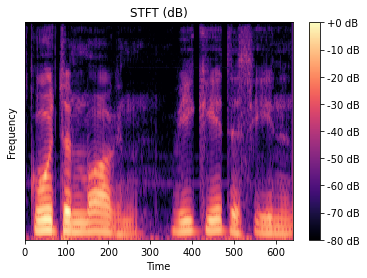

In [100]:
## 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break

librosa.display.specshow(X_train[0][0].numpy(),
                         sr=sr,
                         hop_length=hop_length,
                         win_length=win_length,
                         n_fft=n_fft)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,601,100))
plt.colorbar(format='%+2.0f dB')
plt.title("STFT (dB)")

print(Y_train[0])
print(X_train[0])
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([16, 3, 128, 641]) type: torch.FloatTensor
Y_valid :  torch.Size([16]) type: torch.LongTensor
tensor(1)


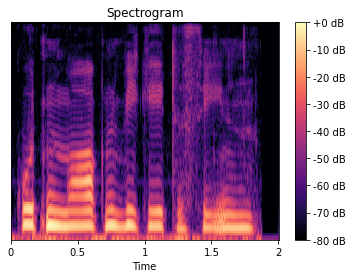

In [101]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

librosa.display.specshow(X_valid[0][0].numpy(), sr=sr,
                        hop_length=hop_length,
                         win_length=win_length,
                         n_fft=n_fft,
                         x_axis='time'
                         )
#plt.xlabel("Time")
#plt.ylabel("Frequency")
#plt.xticks(np.arange(0,600,100))
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")
    
    
print(Y_valid[0])

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET

In [102]:
# 모델
# pretrained

class ResLayer(nn.Module):
    def __init__(self):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(pretrained=True).cuda() 
        self.num_ftrs = self.model.fc.out_features
        
        
        
        self.fc = nn.Sequential(       
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )
        

    def forward(self, x):
        x = self.model(x)
        x  = self.fc(x)
        return x





def model_initialize():
    model = ResLayer().cuda()
    return model

model=model_initialize()

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
print(model)

ResLayer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [104]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

In [105]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [106]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [114]:
#데이터 로더 제작 함수

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mel_params = dict(
                                                         sr = wandb.config.sr,
                                                         n_mels = wandb.config.n_mels,
                                                         n_fft = wandb.config.n_fft,
                                                         win_length = wandb.config.win_length,
                                                         hop_length = wandb.config.hop_length,
                                                         f_max = wandb.config.f_max
                                                   ),
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               worker_init_fn=seed_worker
                                               ) # 순서가 암기되는것을 막기위해.


    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   #normalize=transforms.Normalize((-11.4805,-54.7723,-54.7723),(16.87,19.0226,19.0226)),
                                                   #mfcc_normalize=(53.5582, 217.43),
                                                   mel_params = dict(
                                                         sr = wandb.config.sr,
                                                         n_mels = wandb.config.n_mels,
                                                         n_fft = wandb.config.n_fft,
                                                         win_length = wandb.config.win_length,
                                                         hop_length = wandb.config.hop_length,
                                                         f_max = wandb.config.f_max
                                                   ),
                                                   training=False
                                               ),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = True,
                                                    worker_init_fn=seed_worker) 
    return train_loader,validation_loader



# 학습

In [118]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []



def all_train():
    wandb.init(project="SVD-hyp-sweep2", entity="bub3690",config=run_config)
    data_ind = 1
    check_path ='./checkpoint/melspectrogram_'+str(data_ind)+'_organics_speaker.pt'
    print(check_path)
    #wandb.run.name = 'n'### 여기 수정 ###
    print("config:", dict(wandb.config))    

    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)

    best_train_acc = 0 # accuracy 기록용
    best_valid_acc = 0
    
    best_train_loss = 0
    best_valid_loss = 0

    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)


    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)

        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        #wandb.log({"metric": run.config.param1, "epoch": epoch})
            
        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
            best_train_loss, best_valid_loss = train_loss,valid_loss
            
            wandb.log({"Valid/Loss": best_valid_loss, 
                       "Valid/Accuracy": best_valid_acc,
                      }, step=Epoch)
            #wandb.run.summary.update({"best_valid_{}fold_acc".format(data_ind) : best_valid_acc})
        else:
            # 이전 최고 기록을 log
            wandb.log({"Valid/Loss": best_valid_loss, 
                       "Valid/Accuracy": best_valid_acc,
                      }, step=Epoch)

        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                #여기 최고기록만 갱신하면 5fold 가능.
                
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

In [119]:
wandb.agent(sweep_id, function=all_train,count=10)

wandb: Agent Starting Run: fc9q6qw3 with config:
wandb: 	hop_length: 50
wandb: 	n_fft: 3470
wandb: 	n_mels: 170
wandb: 	win_length: 410
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 170, 'win_length': 410, 'n_fft': 3470, 'hop_length': 50, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0355	 Train Acc:71.67 %  | 	Valid Loss:0.0332 	Valid Acc: 77.98 %

Validation loss decreased (inf --> 0.033242).  Saving model ...

[EPOCH:2]	 Train Loss:0.0291	 Train Acc:82.39 %  | 	Valid Loss:0.0294 	Valid Acc: 84.40 %

Validation loss decreased (0.033242 --> 0.029448).  Saving model ...

[EPOCH:3]	 Train Loss:0.0247	 Train Acc:87.93 %  | 	Valid Loss:0.0293 	Valid Acc: 82.57 %

Validation loss decreased (0.029448 --> 0.029306).  Saving model ...

[EPOCH:4]	 Train Loss:0.0195	 Train Acc:94.95 %  | 	Valid Loss:0.0257 	Valid Acc: 85.32 %

Validation loss decreased (0.029306 --> 0.025702).  Saving model ...

[EPOCH:5]	 Train Loss:0.0165	 Train Acc:97.04 %  | 	Valid Loss:0.0286 	Valid Acc: 81.19 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0143	 Train Acc:97.41 %  | 	Valid

Valid/Accuracy,▁▇▅███▇▇▇▇█▇▇▇▇▇▇
Valid/Loss,█▆▆▄▄▃▃▃▃▃▂▁▁▁▁▁▁
Valid/Accuracy,83.94495
Valid/Loss,0.0207


wandb: Agent Starting Run: xw9lup1w with config:
wandb: 	hop_length: 850
wandb: 	n_fft: 2200
wandb: 	n_mels: 100
wandb: 	win_length: 1580
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 100, 'win_length': 1580, 'n_fft': 2200, 'hop_length': 850, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0413	 Train Acc:61.08 %  | 	Valid Loss:0.0368 	Valid Acc: 72.48 %

Validation loss decreased (inf --> 0.036763).  Saving model ...

[EPOCH:2]	 Train Loss:0.0325	 Train Acc:75.00 %  | 	Valid Loss:0.0346 	Valid Acc: 77.98 %

Validation loss decreased (0.036763 --> 0.034576).  Saving model ...

[EPOCH:3]	 Train Loss:0.0279	 Train Acc:81.53 %  | 	Valid Loss:0.0326 	Valid Acc: 77.06 %

Validation loss decreased (0.034576 --> 0.032556).  Saving model ...

[EPOCH:4]	 Train Loss:0.0229	 Train Acc:88.92 %  | 	Valid Loss:0.0320 	Valid Acc: 77.06 %

Validation loss decreased (0.032556 --> 0.031956).  Saving model ...

[EPOCH:5]	 Train Loss:0.0189	 Train Acc:92.73 %  | 	Valid Loss:0.0320 	Valid Acc: 75.23 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0155	 Train Acc:96.06 %  | 	Val

Valid/Accuracy,▁▇▆▆▆▆▆▆▆▆▆▆██████
Valid/Loss,█▆▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,78.89908
Valid/Loss,0.03043


wandb: Agent Starting Run: fborr1ws with config:
wandb: 	hop_length: 200
wandb: 	n_fft: 2600
wandb: 	n_mels: 50
wandb: 	win_length: 1390
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 50, 'win_length': 1390, 'n_fft': 2600, 'hop_length': 200, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0402	 Train Acc:62.68 %  | 	Valid Loss:0.0345 	Valid Acc: 77.98 %

Validation loss decreased (inf --> 0.034528).  Saving model ...

[EPOCH:2]	 Train Loss:0.0312	 Train Acc:77.59 %  | 	Valid Loss:0.0315 	Valid Acc: 79.82 %

Validation loss decreased (0.034528 --> 0.031453).  Saving model ...

[EPOCH:3]	 Train Loss:0.0275	 Train Acc:82.64 %  | 	Valid Loss:0.0310 	Valid Acc: 75.69 %

Validation loss decreased (0.031453 --> 0.030959).  Saving model ...

[EPOCH:4]	 Train Loss:0.0225	 Train Acc:88.18 %  | 	Valid Loss:0.0290 	Valid Acc: 80.28 %

Validation loss decreased (0.030959 --> 0.028958).  Saving model ...

[EPOCH:5]	 Train Loss:0.0178	 Train Acc:94.70 %  | 	Valid Loss:0.0283 	Valid Acc: 81.19 %

Validation loss decreased (0.028958 --> 0.028314).  Saving model ...

[EPOCH:6]	 Train Loss

Valid/Accuracy,▃▄▁▅▅▅▅▅▅▆▆▆▆▆██████
Valid/Loss,█▆▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid/Accuracy,84.40367
Valid/Loss,0.02529


wandb: Agent Starting Run: i246pd4g with config:
wandb: 	hop_length: 150
wandb: 	n_fft: 1520
wandb: 	n_mels: 130
wandb: 	win_length: 1450
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 130, 'win_length': 1450, 'n_fft': 1520, 'hop_length': 150, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0366	 Train Acc:67.49 %  | 	Valid Loss:0.0296 	Valid Acc: 83.94 %

Validation loss decreased (inf --> 0.029605).  Saving model ...

[EPOCH:2]	 Train Loss:0.0275	 Train Acc:81.90 %  | 	Valid Loss:0.0299 	Valid Acc: 83.03 %

EarlyStopping counter: 1 out of 5

[EPOCH:3]	 Train Loss:0.0228	 Train Acc:87.32 %  | 	Valid Loss:0.0279 	Valid Acc: 81.19 %

Validation loss decreased (0.029605 --> 0.027942).  Saving model ...

[EPOCH:4]	 Train Loss:0.0179	 Train Acc:93.10 %  | 	Valid Loss:0.0282 	Valid Acc: 79.36 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0146	 Train Acc:97.17 %  | 	Valid Loss:0.0267 	Valid Acc: 80.73 %

Validation loss decreased (0.027942 --> 0.026689).  Saving model ...

[EPOCH:6]	 Train Loss:0.0129	 Train Acc:96.80 %  | 	Valid Loss:0.0277 	Valid Acc: 81.65 %


Valid/Accuracy,▇▇▂▂▁▁▇▇██▇▇▇▇▇▇
Valid/Loss,██▆▆▅▅▂▂▁▁▁▁▁▁▁▁
Valid/Accuracy,83.94495
Valid/Loss,0.02351


wandb: Agent Starting Run: r463bp63 with config:
wandb: 	hop_length: 900
wandb: 	n_fft: 3840
wandb: 	n_mels: 60
wandb: 	win_length: 720
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 60, 'win_length': 720, 'n_fft': 3840, 'hop_length': 900, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0461	 Train Acc:54.19 %  | 	Valid Loss:0.0396 	Valid Acc: 63.76 %

Validation loss decreased (inf --> 0.039604).  Saving model ...

[EPOCH:2]	 Train Loss:0.0385	 Train Acc:63.42 %  | 	Valid Loss:0.0379 	Valid Acc: 77.06 %

Validation loss decreased (0.039604 --> 0.037925).  Saving model ...

[EPOCH:3]	 Train Loss:0.0328	 Train Acc:73.77 %  | 	Valid Loss:0.0350 	Valid Acc: 78.90 %

Validation loss decreased (0.037925 --> 0.035007).  Saving model ...

[EPOCH:4]	 Train Loss:0.0282	 Train Acc:82.02 %  | 	Valid Loss:0.0346 	Valid Acc: 77.98 %

Validation loss decreased (0.035007 --> 0.034553).  Saving model ...

[EPOCH:5]	 Train Loss:0.0256	 Train Acc:86.82 %  | 	Valid Loss:0.0336 	Valid Acc: 76.61 %

Validation loss decreased (0.034553 --> 0.033604).  Saving model ...

[EPOCH:6]	 Train Loss:

Valid/Accuracy,▁▇██▇▇▇▇▇▇▇
Valid/Loss,█▆▃▂▁▁▁▁▁▁▁
Valid/Accuracy,77.06422
Valid/Loss,0.03341


wandb: Agent Starting Run: qx19zzpo with config:
wandb: 	hop_length: 200
wandb: 	n_fft: 1710
wandb: 	n_mels: 90
wandb: 	win_length: 2250
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 90, 'win_length': 2250, 'n_fft': 1710, 'hop_length': 200, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 


Run qx19zzpo errored: ParameterError('Target size (1710) must be at least input size (2250)')
wandb: ERROR Run qx19zzpo errored: ParameterError('Target size (1710) must be at least input size (2250)')
wandb: Agent Starting Run: aq3f0ow8 with config:
wandb: 	hop_length: 650
wandb: 	n_fft: 3170
wandb: 	n_mels: 160
wandb: 	win_length: 2500
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 160, 'win_length': 2500, 'n_fft': 3170, 'hop_length': 650, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0394	 Train Acc:63.67 %  | 	Valid Loss:0.0335 	Valid Acc: 76.15 %

Validation loss decreased (inf --> 0.033504).  Saving model ...

[EPOCH:2]	 Train Loss:0.0323	 Train Acc:77.34 %  | 	Valid Loss:0.0317 	Valid Acc: 80.28 %

Validation loss decreased (0.033504 --> 0.031663).  Saving model ...

[EPOCH:3]	 Train Loss:0.0253	 Train Acc:83.74 %  | 	Valid Loss:0.0296 	Valid Acc: 81.19 %

Validation loss decreased (0.031663 --> 0.029561).  Saving model ...

[EPOCH:4]	 Train Loss:0.0201	 Train Acc:91.01 %  | 	Valid Loss:0.0294 	Valid Acc: 78.90 %

Validation loss decreased (0.029561 --> 0.029359).  Saving model ...

[EPOCH:5]	 Train Loss:0.0163	 Train Acc:95.20 %  | 	Valid Loss:0.0286 	Valid Acc: 80.73 %

Validation loss decreased (0.029359 --> 0.028577).  Saving model ...

[EPOCH:6]	 Train Los

Valid/Accuracy,▁▇█▅▇▇▅▅▅▅▅▅
Valid/Loss,█▆▃▃▂▂▁▁▁▁▁▁
Valid/Accuracy,78.89908
Valid/Loss,0.02796


wandb: Agent Starting Run: ja3nlmw5 with config:
wandb: 	hop_length: 600
wandb: 	n_fft: 760
wandb: 	n_mels: 90
wandb: 	win_length: 1700
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 90, 'win_length': 1700, 'n_fft': 760, 'hop_length': 600, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 


Run ja3nlmw5 errored: ParameterError('Target size (760) must be at least input size (1700)')
wandb: ERROR Run ja3nlmw5 errored: ParameterError('Target size (760) must be at least input size (1700)')
wandb: Agent Starting Run: is8xbet7 with config:
wandb: 	hop_length: 500
wandb: 	n_fft: 2100
wandb: 	n_mels: 160
wandb: 	win_length: 1570
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 160, 'win_length': 1570, 'n_fft': 2100, 'hop_length': 500, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0400	 Train Acc:62.44 %  | 	Valid Loss:0.0336 	Valid Acc: 74.31 %

Validation loss decreased (inf --> 0.033557).  Saving model ...

[EPOCH:2]	 Train Loss:0.0309	 Train Acc:76.97 %  | 	Valid Loss:0.0311 	Valid Acc: 76.15 %

Validation loss decreased (0.033557 --> 0.031080).  Saving model ...

[EPOCH:3]	 Train Loss:0.0268	 Train Acc:83.25 %  | 	Valid Loss:0.0301 	Valid Acc: 76.61 %

Validation loss decreased (0.031080 --> 0.030149).  Saving model ...

[EPOCH:4]	 Train Loss:0.0215	 Train Acc:88.18 %  | 	Valid Loss:0.0299 	Valid Acc: 76.61 %

Validation loss decreased (0.030149 --> 0.029939).  Saving model ...

[EPOCH:5]	 Train Loss:0.0177	 Train Acc:93.97 %  | 	Valid Loss:0.0279 	Valid Acc: 80.73 %

Validation loss decreased (0.029939 --> 0.027889).  Saving model ...

[EPOCH:6]	 Train Los

Valid/Accuracy,▁▂▃▃▆▅▅▆▆▆▆██████
Valid/Loss,█▆▅▅▃▃▃▁▁▁▁▁▁▁▁▁▁
Valid/Accuracy,83.48624
Valid/Loss,0.02479


wandb: Agent Starting Run: 2lzedlps with config:
wandb: 	hop_length: 550
wandb: 	n_fft: 1980
wandb: 	n_mels: 130
wandb: 	win_length: 1160
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


./checkpoint/melspectrogram_1_organics_speaker.pt
config: {'sr': 16000, 'n_mels': 130, 'win_length': 1160, 'n_fft': 1980, 'hop_length': 550, 'f_max': 8000}
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0407	 Train Acc:63.79 %  | 	Valid Loss:0.0332 	Valid Acc: 75.69 %

Validation loss decreased (inf --> 0.033194).  Saving model ...

[EPOCH:2]	 Train Loss:0.0309	 Train Acc:77.22 %  | 	Valid Loss:0.0306 	Valid Acc: 79.36 %

Validation loss decreased (0.033194 --> 0.030556).  Saving model ...

[EPOCH:3]	 Train Loss:0.0254	 Train Acc:85.71 %  | 	Valid Loss:0.0309 	Valid Acc: 77.52 %

EarlyStopping counter: 1 out of 5

[EPOCH:4]	 Train Loss:0.0208	 Train Acc:92.86 %  | 	Valid Loss:0.0294 	Valid Acc: 78.90 %

Validation loss decreased (0.030556 --> 0.029397).  Saving model ...

[EPOCH:5]	 Train Loss:0.0174	 Train Acc:96.31 %  | 	Valid Loss:0.0303 	Valid Acc: 78.44 %

EarlyStopping counter: 1 out of 5

[EPOCH:6]	 Train Loss:0.0142	 Train Acc:98.03 %  | 	Valid Loss:0.0271 	Valid Acc: 80.28 %


Valid/Accuracy,▁▇▇▆▆██████
Valid/Loss,█▅▅▄▄▁▁▁▁▁▁
Valid/Accuracy,80.27523
Valid/Loss,0.02711
